In [7]:
#!pip install requirements.txt


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
import pandas as pd
import re
import string

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk.corpus import stopwords, wordnet
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize

import matplotlib.pyplot as plt
from wordcloud import WordCloud

import torch
from transformers import AutoTokenizer, AutoModel

import fasttext

# Descargar la lista de stopwords de NLTK en español
#nltk.download('stopwords')
stop_words = set(stopwords.words('spanish'))

# Descargar los vectores preentrenados en español de fastText
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.es.300.bin.gz
!gunzip cc.es.300.bin.gz


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package average

True

# Lectura del dataset

In [85]:
# Leer el archivo CSV
data = pd.read_csv('data/dataset_Caso_2.csv', skiprows=[0], header=None, names=['tweet'])
display(data)

tweet
0                                                                                ¡Atención! @ElMercurio_cl y @CajaLosAndes destacaron a #CongresoFuturo como una de las 70 organizaciones inspiradoras y de alto impacto que proponen ideas disruptivas para crear valor social que mejore la calidad de vida de las personas. https://t.co/z6EE581U3n
1                                                                                                                                                                                 @CajaLosAndes el dia 9 de abril fui a  @Cinepoliscl y no me aceptaron el codigo para la compra de entradas, sera porque era estreno?? Tuve que pagar precio normal 🙄
2                                                                                                                                                                                                                                                                    @CajaLosAndes Hola, Les envié DM para que me puedan ayudar con un tema por favor.
3                                                                                                                                                                                                                           @CajaLosAndes hola, necesito saber en que tramo de carga familiar estoy  si en A, B. Ya que en la app no me muestra. Sldos
4                                            Convenio DIVBIE - Caja Los Andes\n\nPara el personal Institucional  activo o en condición de retiro y su grupo familiar que se encuentre afiliado. Más información 👉🏻 https://t.co/6kjWUwSnWE\n\nSíguenos en Instagram @divisiondebienestar y en Facebook https://t.co/gzbNFzHaNM https://t.co/yZcQT9B7zH
...                                                                                                                                                                                                                                                                                                                                                ...
2644                                                                                                                                                   @CajaLosAndes Necesito agregar mis datos bancarios para el pago de una licencia, y también activar mi seguro de cesantía por un crédito y sistema arroja error desde ayer. Excelente servicio 😒
2645                                                                                                                                               Me llamaron de @CajaLosAndes para ofrecerme un seguro y me preguntaron si soy casada. Dije que firmé AUC y me responde “entonces soltera”. ¿Vieron por qué era necesario el matrimonio igualitario?
2646                                                           @CajaLosAndes Estimados, buen día... existe alguna otra forma de pagar el seguro caja los andes que no sea ir presencial a una agencia? en Quillota nos están mandando a Quilpué a pagar. Que pasa con los adultos mayores o personas con problema de desplazamiento o que viven lejos?
2647  @yesseni55730686 @tiomattu @CajaLosAndes @gabrielboric Y cuanto alcanzaste a pagar? Cuantas cuotas ?\n\nEn todo caso está todo dentro de norma, tu repactacte y si no actívate el seguro y después dejaste de pagar... Uno responde con su patrimonio.\n\nLo que si te advierto que esto es rápido... Así que debes moverte, ya te notificaron ?
2648                                            @CajaLosAndes @premio_avonni Estimados, buen día... existe alguna otra forma de pagar el seguro caja los andes que no sea ir presencial a una agencia? en Quillota nos están mandando a Quilpué a pagar. Que pasa con los adultos mayores o personas con problema de desplazamiento o que viven lejos?

[2649 rows x 1 columns]

# Limpieza de datos

Al visualizar los datos de forma rápida en el archivo .csv es posible notar que existen varios tweets o muy similares o duplicados. Para esto vale la pena entender qué cantidad de ellos corresponde a qué...

In [86]:
# Diferenciar los tweets duplicados
df = data.drop_duplicates()

# Verificar el número de tweets únicos
print("Número de tweets duplicados:", len(data) - len(df))

Número de tweets duplicados: 431


Además de los tweets duplicados pueden haber algunos muy parecidos, que incluso podrían ser el mismo tweet, pero con alguna palabra restante o adicional... dependiendo del contexto algunos podrían considerarse como duplicados o no. En este caso no serán eliminados

In [87]:
#import nltk
from nltk.tokenize import word_tokenize
#from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from difflib import SequenceMatcher

import nltk
nltk.download('wordnet')
nltk.download('stopwords')

# Cargar las palabras vacías y el lematizador
stop_words = set(stopwords.words('spanish'))
lemmatizer = WordNetLemmatizer()

# Definir una función para comparar la similitud entre dos tweets
def comparar_similitud(tweet1, tweet2):
    # Convertir los tweets a minúsculas
    tweet1 = tweet1.lower()
    tweet2 = tweet2.lower()
    
    # Tokenizar los tweets
    tokens1 = word_tokenize(tweet1)
    tokens2 = word_tokenize(tweet2)
    
    # Eliminar las palabras vacías y lematizar los tokens
    lemmas1 = [lemmatizer.lemmatize(token) for token in tokens1 if token not in stop_words]
    lemmas2 = [lemmatizer.lemmatize(token) for token in tokens2 if token not in stop_words]
    
    # Calcular la similitud entre los tweets
    matcher = SequenceMatcher(None, lemmas1, lemmas2)
    return matcher.ratio()

# Ejemplo de uso de la función
tweet1 = "Este es un tweet de ejemplo"
tweet2 = "Este es un ejemplo de tweet"
similitud = comparar_similitud(tweet1, tweet2)
print("La similitud entre los tweets es:", similitud)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


La similitud entre los tweets es: 0.5


In [90]:
import pandas as pd

# Leer el archivo CSV con los tweets
df = data.drop_duplicates()
# Crear una lista vacía para almacenar los tweets similares
tweets_similares = []

# Iterar a través de los tweets y comparar la similitud con los demás tweets
for i, tweet1 in enumerate(df['tweet']):
    for j, tweet2 in enumerate(df['tweet']):
        if i != j and i < j:
            similitud = comparar_similitud(tweet1, tweet2)
            if similitud >= 0.6:
                tweets_similares.append(tweet1)

# Contar el número de tweets similares
num_tweets_similares = len(set(tweets_similares))

# Imprimir el número de tweets similares
print("Número de tweets similares:", num_tweets_similares)


Número de tweets similares: 200


Ahora, también es importante considerar que pueden haber tweets sin valor alguno, como por ejemplo que contengan solo un EMOJI, solo una palabra o bien sean la respuesta corta de otro tweet

In [23]:
# Cargar los datos en una lista
tweets = data['tweet'].to_list()

# Eliminar las palabras vacías y la puntuación
stop_words = set(stopwords.words('spanish'))
tweets_sin_valor = []
for tweet in tweets:
    tweet_sin_puntuacion = tweet.translate(str.maketrans('', '', string.punctuation))
    tweet_sin_valor = [word.lower() for word in tweet_sin_puntuacion.split() if word.lower() not in stop_words]
    if len(tweet_sin_valor) < 4:
        tweets_sin_valor.append(tweet_sin_valor)

# Verificar los tweets sin valor
print(tweets_sin_valor)


[['cajalosandes', 'hecho'], ['cajalosandes', 'clase', 'tenpo'], ['cajalosandes', '¡listo'], ['cajalosandes', 'listo', 'enviado'], ['cajalosandes', 'hecho', 'gracias'], ['cajalosandes', 'listo'], ['cajalosandes', 'excelente'], ['twitebrio', 'cajalosandes', 'respeto'], ['cajalosandes', 'listo', 'enviado'], ['cajalosandes', 'listo'], ['cajalosandes', 'listo', 'enviado'], ['cajalosandes', 'listo'], ['cajalosandes', 'hecho', 'sds'], ['cajalosandes', 'sistema', 'sucursales'], ['cajalosandes', 'listo'], ['cajalosandes', 'listo'], ['cajalosandes', 'listo', 'enviado'], ['cajalosandes', 'listo'], ['cajalosandes', 'listo'], ['cajalosandes', 'pueden', 'ayudar']]


Aquí se puede ver que algunos tweets son respuestas cortas, por ejemplo:
"hecho, gracias", "listo" o "excelente". Esto no aporta al análisis

También nos aseguramos de que no existan datos de tipo Nan o faltantes dentro de las celdas

In [24]:
data.isna().value_counts()

tweet
False    2649
dtype: int64

Dentro del siguiente ejemplo, también es posible ver que existen algunos tweets que mantienen la calidad de Retweet, que dependiendo del contexto se podrían considerar o no dentro del análisis... En este caso serán considerados, pero teniendo en consideración que muchos son respuestas de la misma cuenta de Caja Los Andes

In [25]:
data["tweet"][5]

'RT @IgualesChile: 🏅Fuimos reconocid@s por @ElMercurio_cl y @CajaLosAndes en el Especial de Innovación Social como una de las "70 iniciativa…'

# Visualización de los datos

Dado que se está trabajando con texto, una de la mejores visualizaciones que se puede obtener de ello son las nubes de palabras... Estas permiten diferenciar las palabras que más se frecuentan dentro del dataset. Cabe destacar que mientras más grande el tamaño del texto, mayor será su frecuencia.

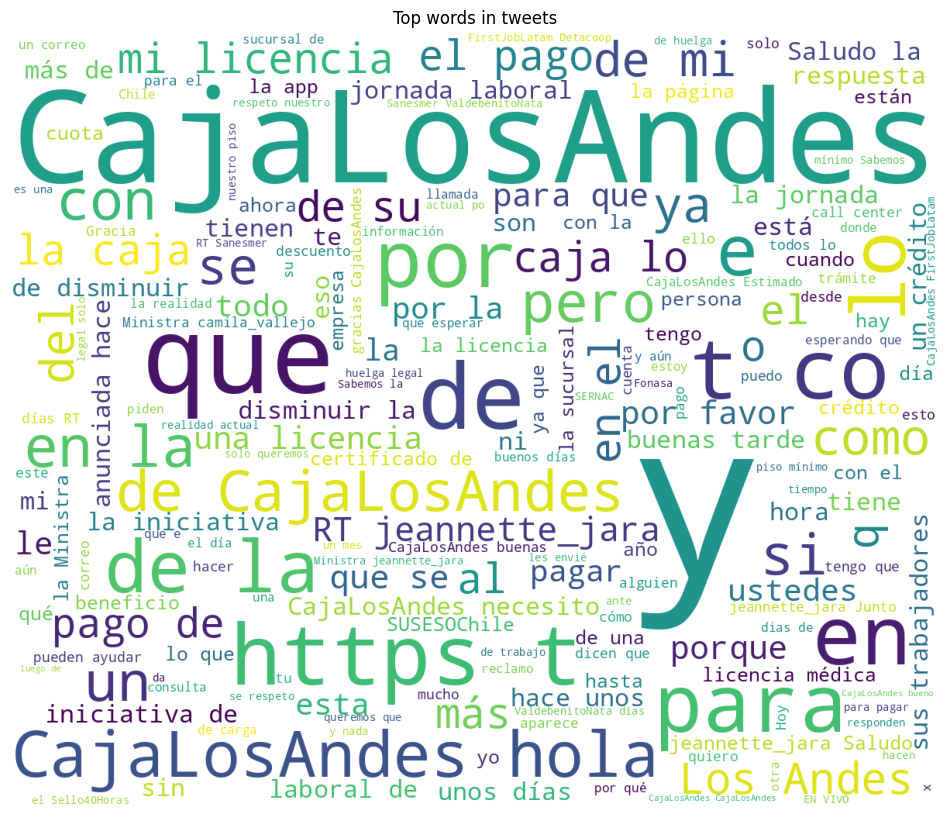

In [29]:
plt.figure(figsize = (12, 12))
text = ' '.join(data['tweet'])
wordcloud = WordCloud(max_font_size=None, background_color='white', width=1200, height=1000).generate(text)
plt.imshow(wordcloud)
plt.title('Top words in tweets')
plt.axis("off")
plt.show()

Dado que existen muchas palabras que no aportan información al análisis, se procede ahora a realizar un preprocesamiento de los datos con la finalidad de extraer la mayor cantidad de información útil.

# Preprocesamiento

La siguiente función tiene como objetivo realizar un preprocesamiento de los tweets almacenados en un archivo CSV. A continuación, se explican los pasos que realiza la función:

- Importación de librerías: La función importa las librerías necesarias para procesar los datos, como Pandas, re (para expresiones regulares), NLTK (Natural Language Toolkit) y las funciones auxiliares preprocess_word, is_valid_word y handle_emojis de un archivo externo llamado aux_functions.

- Descarga de recursos de NLTK: La función descarga la lista de stopwords y la librería de tokenización de NLTK necesarias para preprocesar los tweets.

- Lectura del archivo CSV: La función lee el archivo CSV que contiene los tweets. Los parámetros skiprows y header se utilizan para especificar que el archivo no tiene encabezados y que la primera fila debe ser ignorada.

- Función para limpiar y preprocesar los tweets: La función preprocess_tweet es definida y se encarga de realizar los siguientes pasos de preprocesamiento de los tweets:

    a. Eliminación de URLs: Se utiliza una expresión regular para eliminar las URLs de los tweets.

    b. Eliminación de menciones y hashtags: Se utiliza una expresión regular para eliminar las menciones de usuario y los hashtags de los tweets.

    c. Conversión del texto a minúsculas: Se convierte todo el texto a minúsculas para evitar duplicidades de palabras debido a mayúsculas y minúsculas.

    d. Eliminación de caracteres especiales: Se utiliza otra expresión regular para eliminar caracteres especiales y signos de puntuación del texto.

    e. Eliminación de la etiqueta de retweet: Se elimina la etiqueta "RT" que aparece en los retweets.

    f. Reemplazo de emojis: Se utilizan expresiones regulares para reemplazar los emojis en el texto por la etiqueta "EMO". Esto se realiza para tratar los emojis como palabras y poder procesarlos de la misma forma que las palabras en el resto del texto.

    g. Eliminación de EMO no clasificados: Los emojis no clasificados previamente se eliminan del texto.

    h. Tokenización del texto: Se utiliza la función word_tokenize de NLTK para dividir el texto en tokens (palabras).

    i. Eliminación de palabras vacías: Se eliminan las palabras vacías (stopwords) del idioma español utilizando la lista de stopwords de NLTK.

    j. Eliminación de palabras de una letra: Se eliminan las palabras de una sola letra que no aportan información significativa.

    k. Aplicación del stemming: Finalmente, se utiliza la técnica de stemming de Porter para reducir cada palabra a su raíz (stem). Esto se realiza con el objetivo de tratar las palabras derivadas como si fueran la misma palabra, lo que reduce la complejidad del análisis de texto. Se utiliza la función preprocess_word para limpiar cada palabra antes de aplicar el stemming.

    l. Reconstrucción del tweet preprocesado: Se utiliza la función recon_tokenized para reconstruir el tweet a partir de la lista de tokens preprocesados.

Aplicación de la función de preprocesamiento a todos los tweets: La función aplica la función preprocess_tweet

In [30]:
# Leer el archivo CSV
data = pd.read_csv('data/dataset_Caso_2.csv', skiprows=[0], header=None, names=['tweet'])

# Función para limpiar y preprocesar los tweets
def preprocess_tweet(tweet):
    preprocessed_tweet_words = []
    # Eliminar URLs
    tweet = re.sub(r'http\S+|www\S+|https\S+', '', tweet, flags=re.MULTILINE)

    # Eliminar menciones y hashtags
    tweet = re.sub(r'\@\w+|\#', '', tweet)

    # Convertir el texto a minúsculas
    tweet = tweet.lower()

    regex = '[\\¡\\!\\"\\#\\$\\%\\&\\\'\\(\\)\\*\\+\\,\\-\\.\\/\\:\\;\\<\\=\\>\\?\\@\\[\\\\\\]\\^_\\`\\{\\|\\}\\~]'
    tweet = re.sub(regex , ' ', tweet)

    # Eliminar RT (retweet)
    tweet = re.sub(r'\brt\b', '', tweet)

    # Emojis a EMO
    tweet = re.sub('[\U0001F300-\U0001FAD6]', ' EMO ', tweet)

    # Strip space, " and ' from tweet
    tweet = tweet.strip(' "\'')

    # Reemplazar emojis con EMO_POS o EMO_NEG
    tweet = handle_emojis(tweet)

    # Se eliminan los EMOJIS no clasificados 
    tweet = re.sub(r'\bEMO\b', '', tweet)

    # Reemplazar multiples espacios por uno singular
    tweet = re.sub(r'\s+', ' ', tweet)

    # Tokenizar el texto
    words = word_tokenize(tweet)

    # Eliminar stop-words en español
    stop_words = set(stopwords.words('spanish'))
    words = [word for word in words if word not in stop_words]

    # Eliminar palabras de dos letra
    words = [word for word in words if len(word) > 2]

    # Aplicar stemming
    for word in words:
        porter_stemmer = PorterStemmer()
        word = preprocess_word(word)
        if is_valid_word(word):
            use_stemmer=False
            if use_stemmer:
                word = str(porter_stemmer.stem(word))
            preprocessed_tweet_words.append(word)

    # Reconstruir el tweet preprocesado
    preprocessed_tweet = ' '.join(preprocessed_tweet_words)
    return preprocessed_tweet

# Aplicar la función de preprocesamiento a todos los tweets
data['preprocessed_tweet'] = data['tweet'].apply(preprocess_tweet)

# Eliminar los tweets duplicados del dataframe
data.drop_duplicates(subset=['preprocessed_tweet'], inplace=True)

# Mostrar los primeros 10 tweets preprocesados
display(data.head(10))


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


tweet  \
0     ¡Atención! @ElMercurio_cl y @CajaLosAndes dest...   
1     @CajaLosAndes el dia 9 de abril fui a  @Cinepo...   
2     @CajaLosAndes Hola, Les envié DM para que me p...   
3     @CajaLosAndes hola, necesito saber en que tram...   
4     Convenio DIVBIE - Caja Los Andes\n\nPara el pe...   
...                                                 ...   
2642  @CajaLosAndes  cansa rogar que me devuelvan el...   
2643  @CajaLosAndes Me quedé sin trabajo y debo solo...   
2644  @CajaLosAndes Necesito agregar mis datos banca...   
2645  Me llamaron de @CajaLosAndes para ofrecerme un...   
2647  @yesseni55730686 @tiomattu @CajaLosAndes @gabr...   

                                        tokenized_tweet  \
0     [destacaron, congresofuturo, organizaciones, i...   
1     [dia, abril, aceptaron, codigo, compra, entrad...   
2               [hola, dm, puedan, ayudar, tema, favor]   
3     [hola, necesito, saber, tramo, carga, familiar...   
4     [convenio, divbie, caja, andes, personal, inst...   
...                                                 ...   
2642  [cansa, rogar, devuelvan, dinero, mal, cobrado...   
2643  [trabajo, debo, solo, cuota, fdm, iba, pagar, ...   
2644  [necesito, agregar, datos, bancarios, pago, li...   
2645  [llamaron, ofrecerme, seguro, preguntaron, si,...   
2647  [cuanto, alcanzaste, pagar, cuantas, cuotas, c...   

                                     preprocessed_tweet  
0     destacaron congresofuturo organizaciones inspi...  
1     dia abril aceptaron codigo compra entradas ser...  
2                      hola dm puedan ayudar tema favor  
3     hola necesito saber tramo carga familiar si ap...  
4     convenio divbie caja andes personal institucio...  
...                                                 ...  
2642  cansa rogar devuelvan dinero mal cobrado respu...  
2643  trabajo debo solo cuota fdm iba pagar cuotas v...  
2644  necesito agregar datos bancarios pago licencia...  
2645  llamaron ofrecerme seguro preguntaron si casad...  
2647  cuanto alcanzaste pagar cuantas cuotas caso de...  

[2150 rows x 3 columns]

In [31]:
data['pos_tags'] = data['tokenized_tweet'].apply(nltk.tag.pos_tag)
data

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


tweet  \
0     ¡Atención! @ElMercurio_cl y @CajaLosAndes dest...   
1     @CajaLosAndes el dia 9 de abril fui a  @Cinepo...   
2     @CajaLosAndes Hola, Les envié DM para que me p...   
3     @CajaLosAndes hola, necesito saber en que tram...   
4     Convenio DIVBIE - Caja Los Andes\n\nPara el pe...   
...                                                 ...   
2642  @CajaLosAndes  cansa rogar que me devuelvan el...   
2643  @CajaLosAndes Me quedé sin trabajo y debo solo...   
2644  @CajaLosAndes Necesito agregar mis datos banca...   
2645  Me llamaron de @CajaLosAndes para ofrecerme un...   
2647  @yesseni55730686 @tiomattu @CajaLosAndes @gabr...   

                                        tokenized_tweet  \
0     [destacaron, congresofuturo, organizaciones, i...   
1     [dia, abril, aceptaron, codigo, compra, entrad...   
2               [hola, dm, puedan, ayudar, tema, favor]   
3     [hola, necesito, saber, tramo, carga, familiar...   
4     [convenio, divbie, caja, andes, personal, inst...   
...                                                 ...   
2642  [cansa, rogar, devuelvan, dinero, mal, cobrado...   
2643  [trabajo, debo, solo, cuota, fdm, iba, pagar, ...   
2644  [necesito, agregar, datos, bancarios, pago, li...   
2645  [llamaron, ofrecerme, seguro, preguntaron, si,...   
2647  [cuanto, alcanzaste, pagar, cuantas, cuotas, c...   

                                     preprocessed_tweet  \
0     destacaron congresofuturo organizaciones inspi...   
1     dia abril aceptaron codigo compra entradas ser...   
2                      hola dm puedan ayudar tema favor   
3     hola necesito saber tramo carga familiar si ap...   
4     convenio divbie caja andes personal institucio...   
...                                                 ...   
2642  cansa rogar devuelvan dinero mal cobrado respu...   
2643  trabajo debo solo cuota fdm iba pagar cuotas v...   
2644  necesito agregar datos bancarios pago licencia...   
2645  llamaron ofrecerme seguro preguntaron si casad...   
2647  cuanto alcanzaste pagar cuantas cuotas caso de...   

                                               pos_tags  
0     [(destacaron, NN), (congresofuturo, NN), (orga...  
1     [(dia, NN), (abril, NN), (aceptaron, NN), (cod...  
2     [(hola, NN), (dm, NN), (puedan, NN), (ayudar, ...  
3     [(hola, NN), (necesito, JJ), (saber, NN), (tra...  
4     [(convenio, NN), (divbie, NN), (caja, NN), (an...  
...                                                 ...  
2642  [(cansa, NN), (rogar, NN), (devuelvan, NN), (d...  
2643  [(trabajo, NN), (debo, NN), (solo, NN), (cuota...  
2644  [(necesito, JJ), (agregar, NN), (datos, NN), (...  
2645  [(llamaron, NN), (ofrecerme, NN), (seguro, NN)...  
2647  [(cuanto, NN), (alcanzaste, NN), (pagar, NN), ...  

[2150 rows x 4 columns]

In [32]:
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN


data['wordnet_pos'] = data['pos_tags'].apply(
    lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])

data.head()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


tweet  \
0  ¡Atención! @ElMercurio_cl y @CajaLosAndes dest...   
1  @CajaLosAndes el dia 9 de abril fui a  @Cinepo...   
2  @CajaLosAndes Hola, Les envié DM para que me p...   
3  @CajaLosAndes hola, necesito saber en que tram...   
4  Convenio DIVBIE - Caja Los Andes\n\nPara el pe...   

                                     tokenized_tweet  \
0  [destacaron, congresofuturo, organizaciones, i...   
1  [dia, abril, aceptaron, codigo, compra, entrad...   
2            [hola, dm, puedan, ayudar, tema, favor]   
3  [hola, necesito, saber, tramo, carga, familiar...   
4  [convenio, divbie, caja, andes, personal, inst...   

                                  preprocessed_tweet  \
0  destacaron congresofuturo organizaciones inspi...   
1  dia abril aceptaron codigo compra entradas ser...   
2                   hola dm puedan ayudar tema favor   
3  hola necesito saber tramo carga familiar si ap...   
4  convenio divbie caja andes personal institucio...   

                                            pos_tags  \
0  [(destacaron, NN), (congresofuturo, NN), (orga...   
1  [(dia, NN), (abril, NN), (aceptaron, NN), (cod...   
2  [(hola, NN), (dm, NN), (puedan, NN), (ayudar, ...   
3  [(hola, NN), (necesito, JJ), (saber, NN), (tra...   
4  [(convenio, NN), (divbie, NN), (caja, NN), (an...   

                                         wordnet_pos  
0  [(destacaron, n), (congresofuturo, n), (organi...  
1  [(dia, n), (abril, n), (aceptaron, n), (codigo...  
2  [(hola, n), (dm, n), (puedan, n), (ayudar, n),...  
3  [(hola, n), (necesito, a), (saber, n), (tramo,...  
4  [(convenio, n), (divbie, n), (caja, n), (andes...

In [33]:
stop_words = set(stopwords.words('spanish'))
wnl = WordNetLemmatizer()

data['lemmatized'] = data['wordnet_pos'].apply(
    lambda x: [wnl.lemmatize(word, tag) for word, tag in x])

data['lemmatized'] = data['lemmatized'].apply(
    lambda x: [word for word in x if word not in stop_words])

data['lemma_str'] = [' '.join(map(str, l)) for l in data['lemmatized']]

data.head()

tweet  \
0  ¡Atención! @ElMercurio_cl y @CajaLosAndes dest...   
1  @CajaLosAndes el dia 9 de abril fui a  @Cinepo...   
2  @CajaLosAndes Hola, Les envié DM para que me p...   
3  @CajaLosAndes hola, necesito saber en que tram...   
4  Convenio DIVBIE - Caja Los Andes\n\nPara el pe...   

                                     tokenized_tweet  \
0  [destacaron, congresofuturo, organizaciones, i...   
1  [dia, abril, aceptaron, codigo, compra, entrad...   
2            [hola, dm, puedan, ayudar, tema, favor]   
3  [hola, necesito, saber, tramo, carga, familiar...   
4  [convenio, divbie, caja, andes, personal, inst...   

                                  preprocessed_tweet  \
0  destacaron congresofuturo organizaciones inspi...   
1  dia abril aceptaron codigo compra entradas ser...   
2                   hola dm puedan ayudar tema favor   
3  hola necesito saber tramo carga familiar si ap...   
4  convenio divbie caja andes personal institucio...   

                                            pos_tags  \
0  [(destacaron, NN), (congresofuturo, NN), (orga...   
1  [(dia, NN), (abril, NN), (aceptaron, NN), (cod...   
2  [(hola, NN), (dm, NN), (puedan, NN), (ayudar, ...   
3  [(hola, NN), (necesito, JJ), (saber, NN), (tra...   
4  [(convenio, NN), (divbie, NN), (caja, NN), (an...   

                                         wordnet_pos  \
0  [(destacaron, n), (congresofuturo, n), (organi...   
1  [(dia, n), (abril, n), (aceptaron, n), (codigo...   
2  [(hola, n), (dm, n), (puedan, n), (ayudar, n),...   
3  [(hola, n), (necesito, a), (saber, n), (tramo,...   
4  [(convenio, n), (divbie, n), (caja, n), (andes...   

                                          lemmatized  \
0  [destacaron, congresofuturo, organizaciones, i...   
1  [dia, abril, aceptaron, codigo, compra, entrad...   
2            [hola, dm, puedan, ayudar, tema, favor]   
3  [hola, necesito, saber, tramo, carga, familiar...   
4  [convenio, divbie, caja, andes, personal, inst...   

                                           lemma_str  
0  destacaron congresofuturo organizaciones inspi...  
1  dia abril aceptaron codigo compra entradas ser...  
2                   hola dm puedan ayudar tema favor  
3  hola necesito saber tramo carga familiar si ap...  
4  convenio divbie caja andes personal institucio...

Ahora, tras el preprocesamiento las palabras más frecuentes del dataset quedan de la siguiente manera:

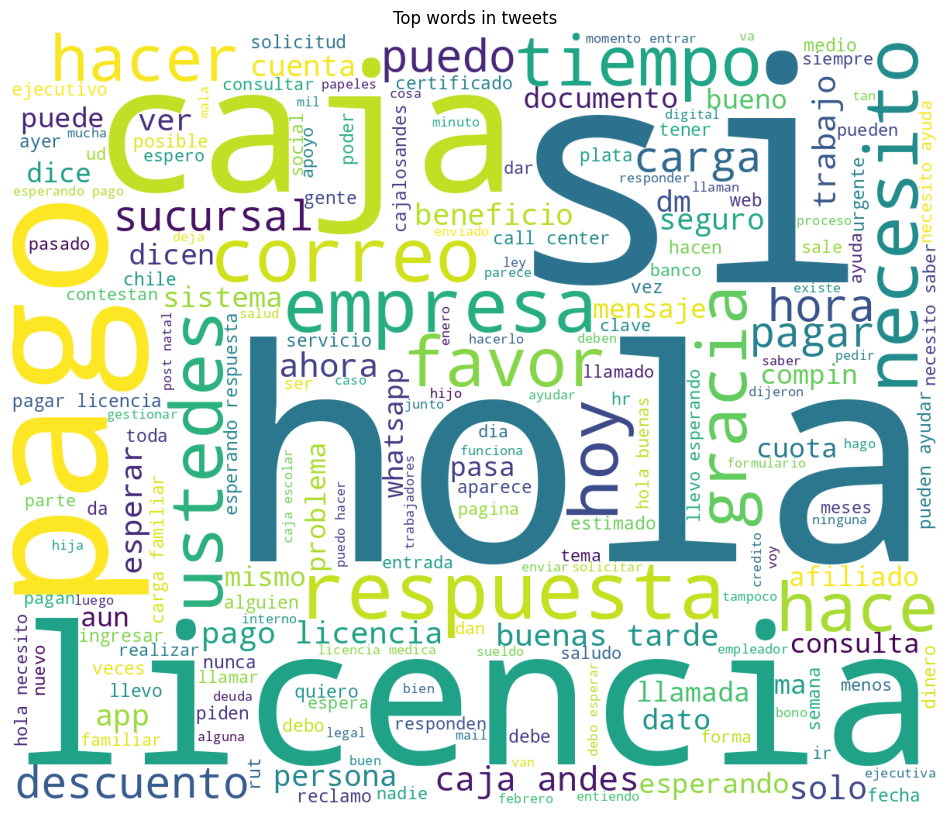

In [103]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

plt.figure(figsize = (12, 12))
text = ' '.join(data['lemma_str'])
wordcloud = WordCloud(max_font_size=None, background_color='white', width=1200, height=1000).generate(text)
plt.imshow(wordcloud)
plt.title('Top words in tweets')
plt.axis("off")
plt.show()

# Procesamiento y clasificación

Para poder definir fronteras de datos dentro del modelo es importarte utilizar librerías y modelos pre entrenados que tengan relación con el análisis de sentimientos y vectorización de palabras. Esto se hace dado que no se cuenta con una base de datos etiquetada por lo tanto es importante destacar que los métodos a implementar guardan relación con modelos no supervisados.

## distilBERT

In [36]:
# Cargar el tokenizador y el modelo pre-entrenado de DistilBERT en español
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-multilingual-cased")
model = AutoModel.from_pretrained("distilbert-base-multilingual-cased")

def get_distilbert_embeddings(text):
    # Tokenizar el texto y convertirlo en tensores
    inputs = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=512,
        padding="max_length",
        return_attention_mask=True,
        return_tensors="pt",
    )

    # Obtener los embeddings con el modelo DistilBERT
    with torch.no_grad():
        outputs = model(**inputs)
        embeddings = outputs.last_hidden_state[:, 0, :].numpy()

    return embeddings

# Aplicar DistilBERT para obtener embeddings de los tweets preprocesados
data["distilbert_embeddings"] = data["lemma_str"].apply(get_distilbert_embeddings)

# Mostrar los primeros 5 tweets con sus embeddings
print(data[["tweet", "distilbert_embeddings"]].head(5))


Some weights of the model checkpoint at distilbert-base-multilingual-cased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


                                  preprocessed_tweet  \
0  destacaron congresofuturo organizaciones inspi...   
1  dia abril aceptaron codigo compra entradas ser...   
2                   hola dm puedan ayudar tema favor   
3  hola necesito saber tramo carga familiar si ap...   
4  convenio divbie caja andes personal institucio...   

                               distilbert_embeddings  
0  [[-0.17890285, -0.1588103, 0.23160869, 0.11977...  
1  [[0.16236931, -0.19685182, -0.11867791, 0.2070...  
2  [[0.07614494, -0.11780073, 0.49915227, 0.18506...  
3  [[0.14514875, -0.061178286, 0.16490802, 0.1328...  
4  [[-0.026629217, -0.15750529, 0.28171986, 0.056...  


In [38]:
data

tweet  \
0     ¡Atención! @ElMercurio_cl y @CajaLosAndes dest...   
1     @CajaLosAndes el dia 9 de abril fui a  @Cinepo...   
2     @CajaLosAndes Hola, Les envié DM para que me p...   
3     @CajaLosAndes hola, necesito saber en que tram...   
4     Convenio DIVBIE - Caja Los Andes\n\nPara el pe...   
...                                                 ...   
2642  @CajaLosAndes  cansa rogar que me devuelvan el...   
2643  @CajaLosAndes Me quedé sin trabajo y debo solo...   
2644  @CajaLosAndes Necesito agregar mis datos banca...   
2645  Me llamaron de @CajaLosAndes para ofrecerme un...   
2647  @yesseni55730686 @tiomattu @CajaLosAndes @gabr...   

                                        tokenized_tweet  \
0     [destacaron, congresofuturo, organizaciones, i...   
1     [dia, abril, aceptaron, codigo, compra, entrad...   
2               [hola, dm, puedan, ayudar, tema, favor]   
3     [hola, necesito, saber, tramo, carga, familiar...   
4     [convenio, divbie, caja, andes, personal, inst...   
...                                                 ...   
2642  [cansa, rogar, devuelvan, dinero, mal, cobrado...   
2643  [trabajo, debo, solo, cuota, fdm, iba, pagar, ...   
2644  [necesito, agregar, datos, bancarios, pago, li...   
2645  [llamaron, ofrecerme, seguro, preguntaron, si,...   
2647  [cuanto, alcanzaste, pagar, cuantas, cuotas, c...   

                                     preprocessed_tweet  \
0     destacaron congresofuturo organizaciones inspi...   
1     dia abril aceptaron codigo compra entradas ser...   
2                      hola dm puedan ayudar tema favor   
3     hola necesito saber tramo carga familiar si ap...   
4     convenio divbie caja andes personal institucio...   
...                                                 ...   
2642  cansa rogar devuelvan dinero mal cobrado respu...   
2643  trabajo debo solo cuota fdm iba pagar cuotas v...   
2644  necesito agregar datos bancarios pago licencia...   
2645  llamaron ofrecerme seguro preguntaron si casad...   
2647  cuanto alcanzaste pagar cuantas cuotas caso de...   

                                               pos_tags  \
0     [(destacaron, NN), (congresofuturo, NN), (orga...   
1     [(dia, NN), (abril, NN), (aceptaron, NN), (cod...   
2     [(hola, NN), (dm, NN), (puedan, NN), (ayudar, ...   
3     [(hola, NN), (necesito, JJ), (saber, NN), (tra...   
4     [(convenio, NN), (divbie, NN), (caja, NN), (an...   
...                                                 ...   
2642  [(cansa, NN), (rogar, NN), (devuelvan, NN), (d...   
2643  [(trabajo, NN), (debo, NN), (solo, NN), (cuota...   
2644  [(necesito, JJ), (agregar, NN), (datos, NN), (...   
2645  [(llamaron, NN), (ofrecerme, NN), (seguro, NN)...   
2647  [(cuanto, NN), (alcanzaste, NN), (pagar, NN), ...   

                                            wordnet_pos  \
0     [(destacaron, n), (congresofuturo, n), (organi...   
1     [(dia, n), (abril, n), (aceptaron, n), (codigo...   
2     [(hola, n), (dm, n), (puedan, n), (ayudar, n),...   
3     [(hola, n), (necesito, a), (saber, n), (tramo,...   
4     [(convenio, n), (divbie, n), (caja, n), (andes...   
...                                                 ...   
2642  [(cansa, n), (rogar, n), (devuelvan, n), (dine...   
2643  [(trabajo, n), (debo, n), (solo, n), (cuota, n...   
2644  [(necesito, a), (agregar, n), (datos, n), (ban...   
2645  [(llamaron, n), (ofrecerme, n), (seguro, n), (...   
2647  [(cuanto, n), (alcanzaste, n), (pagar, n), (cu...   

                                             lemmatized  \
0     [destacaron, congresofuturo, organizaciones, i...   
1     [dia, abril, aceptaron, codigo, compra, entrad...   
2               [hola, dm, puedan, ayudar, tema, favor]   
3     [hola, necesito, saber, tramo, carga, familiar...   
4     [convenio, divbie, caja, andes, personal, inst...   
...                                                 ...   
2642  [cansa, rogar, devuelvan, dinero, mal, cobrado...   
2643  [trabajo, debo, solo, cuota

## Fasttext

In [9]:
# Carga el modelo
fasttext_model = fasttext.load_model("cc.es.300.bin")


--2023-05-08 01:57:06--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.es.300.bin.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 52.84.162.51, 52.84.162.119, 52.84.162.20, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|52.84.162.51|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4500107671 (4.2G) [application/octet-stream]
Saving to: ‘cc.es.300.bin.gz’

cc.es.300.bin.gz    100%[===================>]   4.19G   142MB/s    in 35s     

2023-05-08 01:57:41 (123 MB/s) - ‘cc.es.300.bin.gz’ saved [4500107671/4500107671]



In [4]:
# Carga el modelo
fasttext_model = fasttext.load_model("cc.es.300.bin")

In [93]:
import numpy as np

def get_tweet_sentiment_vector(tokens, fasttext_model):
    sentiment_vectors = []
    
    for token in tokens:
        sentiment_vector = fasttext_model.get_word_vector(token)
        sentiment_vectors.append(sentiment_vector)
    
    avg_sentiment_vector = np.mean(sentiment_vectors, axis=0)
    return avg_sentiment_vector

data["sentiment_vector"] = data["tokenized_tweet"].apply(lambda x: get_tweet_sentiment_vector(x, fasttext_model))


## Textblob

In [94]:
from textblob import TextBlob

def get_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity, blob.sentiment.subjectivity

data["preprocessed_tweet"] = data["preprocessed_tweet"].astype(str)
data[["polarity", "subjectivity"]] = data["preprocessed_tweet"].apply(lambda x: get_sentiment(x)).apply(pd.Series)


In [97]:
data[["tweet", "distilbert_embeddings", "sentiment_vector", "polarity", "subjectivity"]]

tweet  \
0     ¡Atención! @ElMercurio_cl y @CajaLosAndes dest...   
1     @CajaLosAndes el dia 9 de abril fui a  @Cinepo...   
2     @CajaLosAndes Hola, Les envié DM para que me p...   
3     @CajaLosAndes hola, necesito saber en que tram...   
4     Convenio DIVBIE - Caja Los Andes\n\nPara el pe...   
...                                                 ...   
2145  @CajaLosAndes  cansa rogar que me devuelvan el...   
2146  @CajaLosAndes Me quedé sin trabajo y debo solo...   
2147  @CajaLosAndes Necesito agregar mis datos banca...   
2148  Me llamaron de @CajaLosAndes para ofrecerme un...   
2149  @yesseni55730686 @tiomattu @CajaLosAndes @gabr...   

                                  distilbert_embeddings  \
0     [[-1.78902850e-01 -1.58810303e-01  2.31608689e...   
1     [[ 1.62369311e-01 -1.96851820e-01 -1.18677907e...   
2     [[ 7.61449412e-02 -1.17800727e-01  4.99152273e...   
3     [[ 1.45148754e-01 -6.11782856e-02  1.64908022e...   
4     [[-2.66292170e-02 -1.57505289e-01  2.81719863e...   
...                                                 ...   
2145  [[ 1.01618066e-01 -1.26099631e-01 -1.87676802e...   
2146  [[-6.14595041e-03 -1.36513174e-01  2.32283063e...   
2147  [[ 7.27963746e-02 -2.97492921e-01  2.64728606e...   
2148  [[-1.10492088e-01 -1.76348817e-02  5.76325618e...   
2149  [[-6.01883978e-02 -1.40870601e-01 -6.70971349e...   

                                       sentiment_vector  polarity  \
0     [0.0698546, 0.015458735, -0.040262237, -0.0129...  0.033333   
1     [0.059835758, 0.015395064, -0.024453575, -0.00...  0.150000   
2     [0.05375052, -0.002522332, -0.029186472, -0.00...  0.000000   
3     [0.07715899, 0.009129942, -0.045900013, -0.018...  0.375000   
4     [0.055425067, 0.011498561, -0.03386784, -0.001...  0.187500   
...                                                 ...       ...   
2145  [0.09492328, 0.016173132, -0.017286431, -0.011...  0.000000   
2146  [0.07858308, 0.0062355753, -0.025190197, -0.01...  0.000000   
2147  [0.069523744, 0.020492706, -0.009499615, -0.01...  0.000000   
2148  [0.085081704, 0.013954691, -0.023272721, -0.00...  0.000000   
2149  [0.08544822, 0.021252593, -0.036360983, -0.023...  0.000000   

      subjectivity  
0         0.066667  
1         0.650000  
2         0.000000  
3         0.500000  
4         0.400000  
...            ...  
2145      0.000000  
2146      0.000000  
2147      0.000000  
2148      0.000000  
2149      0.000000  

[2150 rows x 5 columns]

## Primer Clustering utilizando solo la librería textblob

In [101]:
features_matrix = data[["polarity", "subjectivity"]].values

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
normalized_features = scaler.fit_transform(features_matrix)

from sklearn.cluster import KMeans

n_clusters = 3  # Se buscan 3 clústeres [Positivo, Neutral y Negativo]
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
data["cluster"] = kmeans.fit_predict(normalized_features)
display(data[["tweet", "cluster"]])

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


tweet  cluster
0     ¡Atención! @ElMercurio_cl y @CajaLosAndes dest...        0
1     @CajaLosAndes el dia 9 de abril fui a  @Cinepo...        1
2     @CajaLosAndes Hola, Les envié DM para que me p...        0
3     @CajaLosAndes hola, necesito saber en que tram...        1
4     Convenio DIVBIE - Caja Los Andes\n\nPara el pe...        1
...                                                 ...      ...
2145  @CajaLosAndes  cansa rogar que me devuelvan el...        0
2146  @CajaLosAndes Me quedé sin trabajo y debo solo...        0
2147  @CajaLosAndes Necesito agregar mis datos banca...        0
2148  Me llamaron de @CajaLosAndes para ofrecerme un...        0
2149  @yesseni55730686 @tiomattu @CajaLosAndes @gabr...        0

[2150 rows x 2 columns]

In [102]:
# Agrupar los tweets según su sentimiento
df_1 = data[data['cluster'] == 0]
df_2 = data[data['cluster'] == 1]
df_3 = data[data['cluster'] == 2]

# Visualizar el número de tweets en cada grupo
print('Tweets 1:', len(df_1))
print('Tweets 2:', len(df_2))
print('Tweets 3:', len(df_3))

Tweets 1: 1972
Tweets 2: 166
Tweets 3: 12


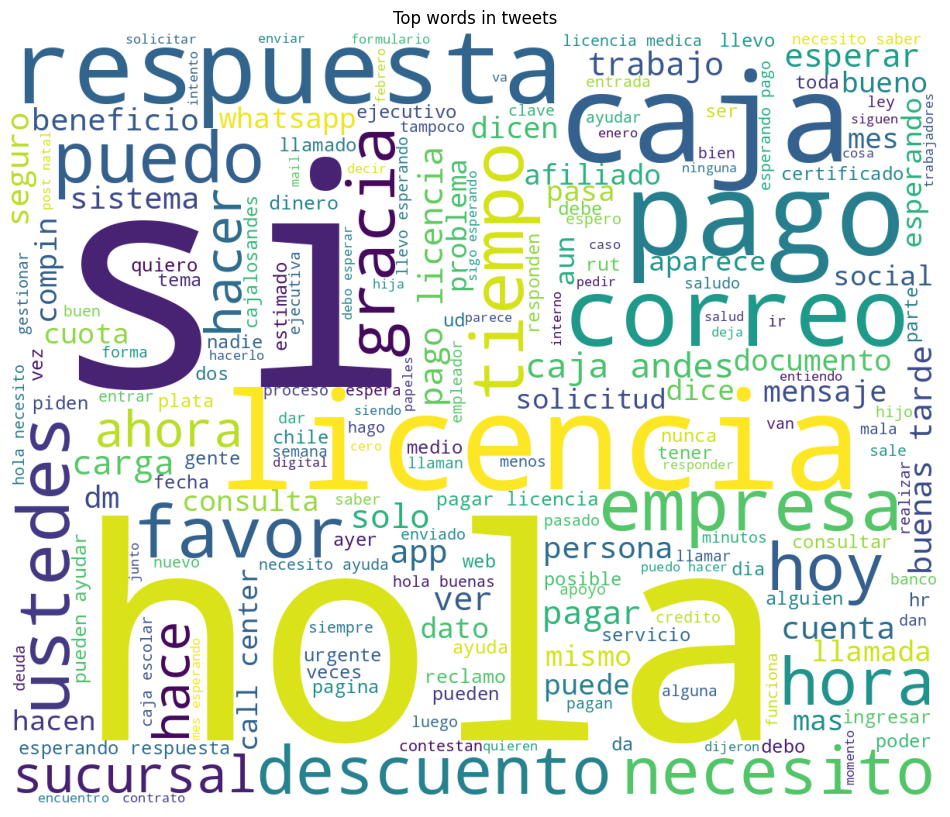

In [103]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

plt.figure(figsize = (12, 12))
text = ' '.join(df_1['preprocessed_tweet'])
wordcloud = WordCloud(max_font_size=None, background_color='white', width=1200, height=1000).generate(text)
plt.imshow(wordcloud)
plt.title('Top words in tweets')
plt.axis("off")
plt.show()

In [106]:
df_1[["tweet"]]

tweet
0     ¡Atención! @ElMercurio_cl y @CajaLosAndes dest...
2     @CajaLosAndes Hola, Les envié DM para que me p...
5     RT @IgualesChile: 🏅Fuimos reconocid@s por @ElM...
6     @CajaLosAndes Buen día, les escribo porque nue...
8     Hola a todos!, espero que estén teniendo una b...
...                                                 ...
2145  @CajaLosAndes  cansa rogar que me devuelvan el...
2146  @CajaLosAndes Me quedé sin trabajo y debo solo...
2147  @CajaLosAndes Necesito agregar mis datos banca...
2148  Me llamaron de @CajaLosAndes para ofrecerme un...
2149  @yesseni55730686 @tiomattu @CajaLosAndes @gabr...

[1972 rows x 1 columns]

Dentro de este grupo se ven comentarios bastante positivos. Se ve que varios de ellos tienen que ver con reconocimientos, equipos externos, etc... El problema principal radica en que este grupo es demasiado grande y podría tener un margen de error enorme.

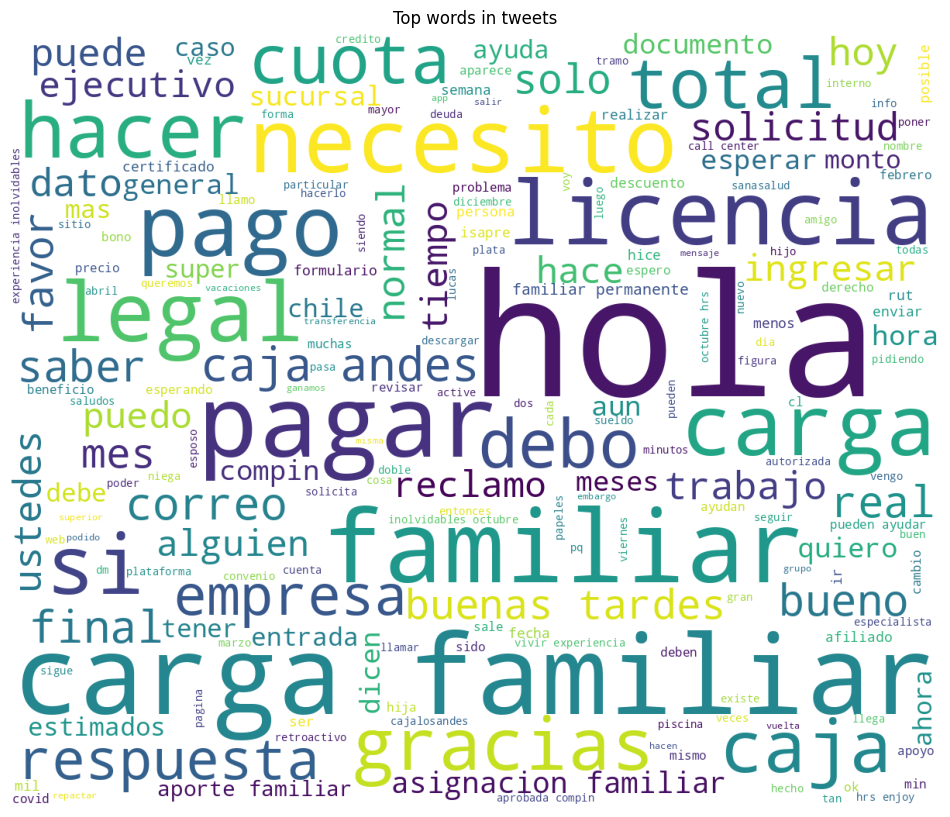

In [104]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

plt.figure(figsize = (12, 12))
text = ' '.join(df_2['preprocessed_tweet'])
wordcloud = WordCloud(max_font_size=None, background_color='white', width=1200, height=1000).generate(text)
plt.imshow(wordcloud)
plt.title('Top words in tweets')
plt.axis("off")
plt.show()

In [107]:
df_2[["tweet"]]

tweet
1     @CajaLosAndes el dia 9 de abril fui a  @Cinepo...
3     @CajaLosAndes hola, necesito saber en que tram...
4     Convenio DIVBIE - Caja Los Andes\n\nPara el pe...
7     @CajaLosAndes por ley y cito " D.F.L. N° 44, c...
17    RT @CampeonatoCL: 👏👏 Felicitaciones @udechilef...
...                                                 ...
2087  Es normal que @CajaLosAndes RECHACE pagar una ...
2108  @CajaLosAndes Hola, buenas tardes.\n¿Cómo pued...
2116  Por favor @CajaLosAndes necesito su ayuda ya q...
2120  @CajaLosAndes habrá alguna posibilidad de paga...
2134  ¡Hola! ¿Me ayudan?\n\nTaloo fue seleccionado p...

[166 rows x 1 columns]

Dentro de este segundo grupo podría haber una connotación neutra, pero no es lo suficientemente clara, por tanto tampoco se podría tener una certeza de aquello

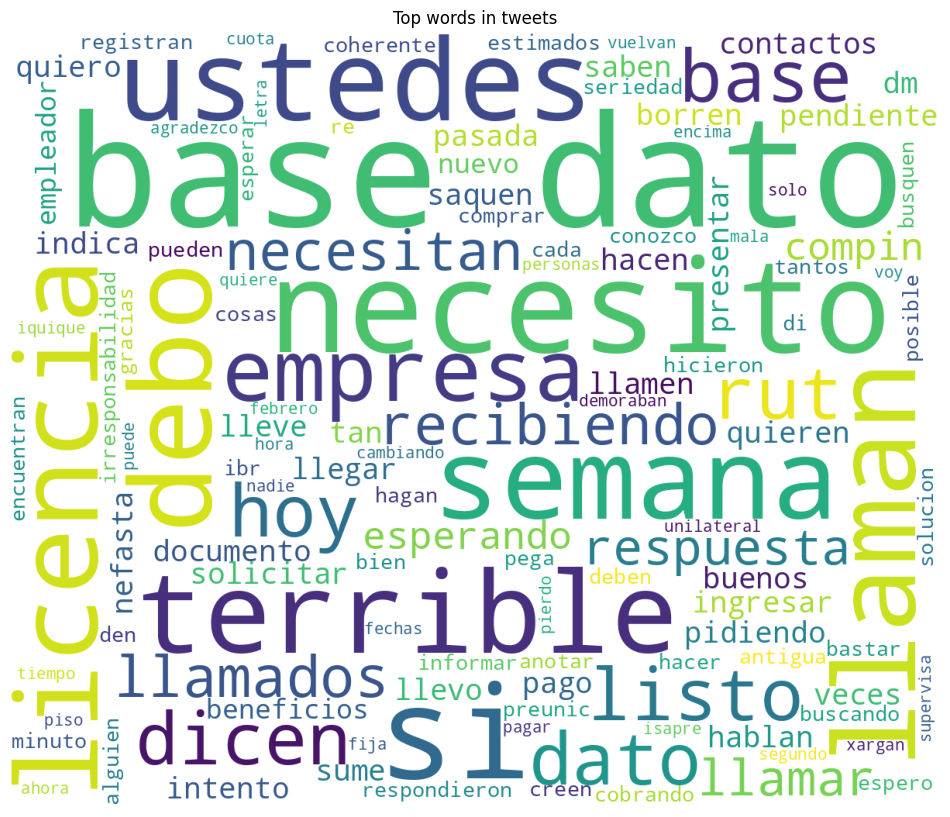

In [105]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

plt.figure(figsize = (12, 12))
text = ' '.join(df_3['preprocessed_tweet'])
wordcloud = WordCloud(max_font_size=None, background_color='white', width=1200, height=1000).generate(text)
plt.imshow(wordcloud)
plt.title('Top words in tweets')
plt.axis("off")
plt.show()

In [108]:
df_3[["tweet"]]

tweet
78    @CajaLosAndes terrible. Me hacen llegar una no...
117   @CajaLosAndes Buenos días, necesito solicitar ...
242   @CajaLosAndes Ustedes saben la base de datos.....
490   @CajaLosAndes Necesito que me saquen de la bas...
636   @CajaLosAndes Para que si su base de datos es ...
830   @CajaLosAndes Estimados como es posible que es...
1054  @CajaLosAndes 2 semanas recibiendo llamados de...
1604  @CajaLosAndes O sea, tengo que anotar cada una...
1829  @CajaLosAndes Gracias por la respuesta, pero ¿...
1945  @florecirockera No es la única empresa , @Caja...
2068  Que terrible de mala atención en @CajaLosAndes...
2124  @Gringui72633025 @SUSESOChile @CajaLosAndes Co...

Ahora, dentro de este último grupo si existe una connotación negativa clara y referente a quejas y reclamos. El problema resulta ser que el cluster es pequeño, y la cantidad de reclamos y comentarios positivos, a simple vista es mucho mayor...

Entonces... dado que el desempeño tiene un margen de mejora bastante amplio, se pueden implementar técnicas adicionales utilizando los recursos que hemos extraído anteriormente.

# Unificación de los modelos

Ahora, si agregamos la característica del modelo distilBERT, el vector de sentimientos de fasttext y el grado de subjetividad que ofrece la librería textblob de python dentro del procesamiento...

In [ ]:
import numpy as np

def convert_to_numpy(column):
    if isinstance(column, str):
        # Convierte la cadena en una lista
        column = column.strip('[]').split()
    return np.array(column, dtype=np.float32)

data["distilbert_embeddings"] = data["columna1"].apply(convert_to_numpy)
data["sentiment_vector"] = data["sentiment_vector"].apply(convert_to_numpy)

def norm_value(vector):
    return np.linalg.norm(vector)

data['distilbert_embeddings_value'] = data['distilbert_embeddings'].apply(norm_value)
data['sentiment_vector_value'] = data['sentiment_vector'].apply(norm_value)


In [70]:
features_matrix = data[["distilbert_embeddings_value", "sentiment_vector_value", "polarity", "subjectivity"]].values

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
normalized_features = scaler.fit_transform(features_matrix)

from sklearn.cluster import KMeans

n_clusters = 3  # Se buscan 3 clústeres [Positivo, Neutral y Negativo]
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
data["cluster"] = kmeans.fit_predict(normalized_features)

In [73]:
# Agrupar los tweets según su sentimiento
df_1 = data[data['cluster'] == 0]
df_2 = data[data['cluster'] == 1]
df_3 = data[data['cluster'] == 2]

# Visualizar el número de tweets en cada grupo
print('Tweets 1:', len(df_1))
print('Tweets 2:', len(df_2))
print('Tweets 3:', len(df_3))

Tweets 1: 159
Tweets 2: 1026
Tweets 3: 965


Esta distribución de datos puede verse un poco más adecuada al contexto de una separación de datos de 3 sentimientos [Positivo, Negativo y Neutro], por lo cual procedemos a ver algunos ejemplos...

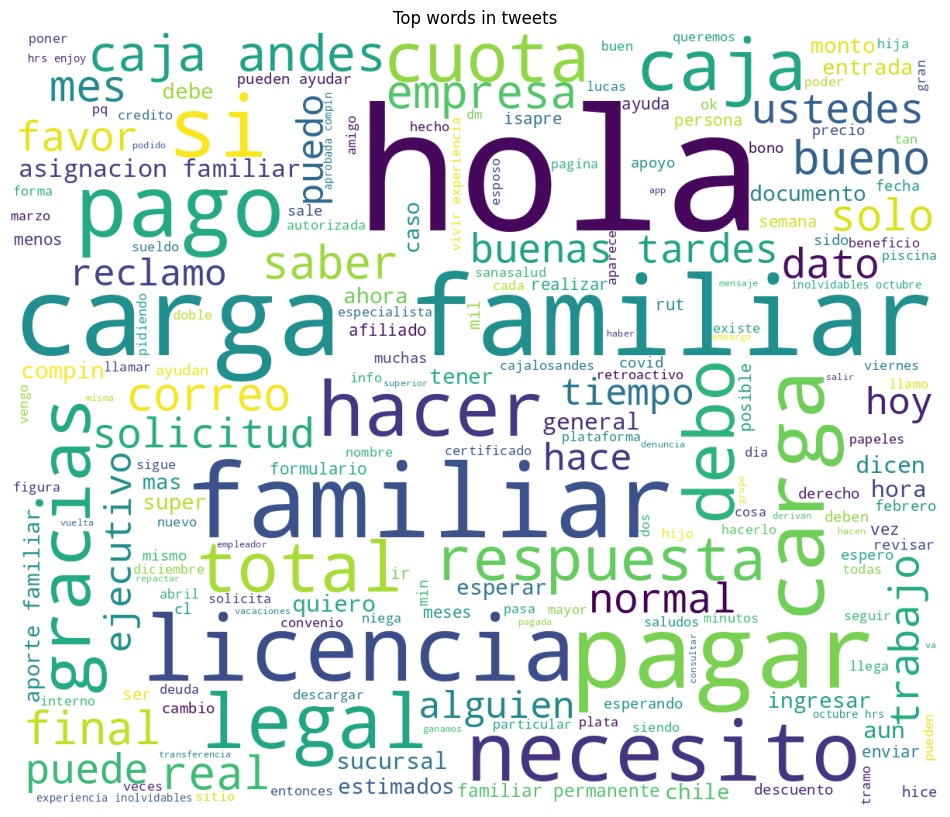

In [74]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

plt.figure(figsize = (12, 12))
text = ' '.join(df_1['preprocessed_tweet'])
wordcloud = WordCloud(max_font_size=None, background_color='white', width=1200, height=1000).generate(text)
plt.imshow(wordcloud)
plt.title('Top words in tweets')
plt.axis("off")
plt.show()

In [83]:
df_1[["tweet"]]

tweet
1                                                                                                                                          @CajaLosAndes el dia 9 de abril fui a  @Cinepoliscl y no me aceptaron el codigo para la compra de entradas, sera porque era estreno?? Tuve que pagar precio normal 🙄
3                                                                                                                                                                                    @CajaLosAndes hola, necesito saber en que tramo de carga familiar estoy  si en A, B. Ya que en la app no me muestra. Sldos
4     Convenio DIVBIE - Caja Los Andes\n\nPara el personal Institucional  activo o en condición de retiro y su grupo familiar que se encuentre afiliado. Más información 👉🏻 https://t.co/6kjWUwSnWE\n\nSíguenos en Instagram @divisiondebienestar y en Facebook https://t.co/gzbNFzHaNM https://t.co/yZcQT9B7zH
7            @CajaLosAndes por ley y cito " D.F.L. N° 44, citado en Fuentes, norma que los subsidios se deben\npagar, por lo menos, con la misma periodicidad que la remuneración, sin que pueda ser, en caso\nalguno, superior a un mes." @SUSESOChile , indica que no mas de 72 hrs,para pagar 2 cuota de LME
17                                                                                                                                                             RT @CampeonatoCL: 👏👏 Felicitaciones @udechilefem 🔵🔴\n\nTriunfo 2-1 en la semifinal de vuelta y los pasajes para la final de Sausalito 🎟🏟\n\nNos…
...                                                                                                                                                                                                                                                                                                         ...
2056                                                                               @CajaLosAndes hola, porqué siempre el endeudarse resulta tan fácil, pero querer pagar el saldo total de un crédito cuesta tanto trabajo hacerlo. Horas buscándo en la página donde pagar y nada de nada. Me ayudan por favor
2087                                         Es normal que @CajaLosAndes RECHACE pagar una licencia Covid (8 días) ya aprobada por el Compin argumentando que la trabajadora dependiente debe tener un contrato de al menos 6 meses? No se supone se deben pagar si o si todas? @SeremiSaludRM @ministeriosalud
2108                                                                                                                                                                                @CajaLosAndes Hola, buenas tardes.\n¿Cómo puedo agregar a mi padre como carga familiar?\nLes agradezco si me pueden ayudar.
2120                                                                         @CajaLosAndes habrá alguna posibilidad de pagar  un préstamo por anticipado y que me condonen los intereses? Fui a la caja y me dicen que debo pagar el total de lo que resta, estoy pagando dos veces el monto inicial!!! @SERNAC
2134                  ¡Hola! ¿Me ayudan?\n\nTaloo fue seleccionado por Caja Los Andes para su programa de aceleración. Necesitamos tu voto para que podamos ganar el fondo TECLA de Caja Los Andes: https://t.co/6XJQVFoHcC\n\n¡Esto nos ayudaría a seguir siendo un aporte real a la empleabilidad!\nGracias🙌⭐

[159 rows x 1 columns]

Dentro de este clustering prima bastante el concepto familiar, el saludo y temas acordes a la caja... considerando además los ejemplos del dataset es posible asociar esto a connotaciones positivas.

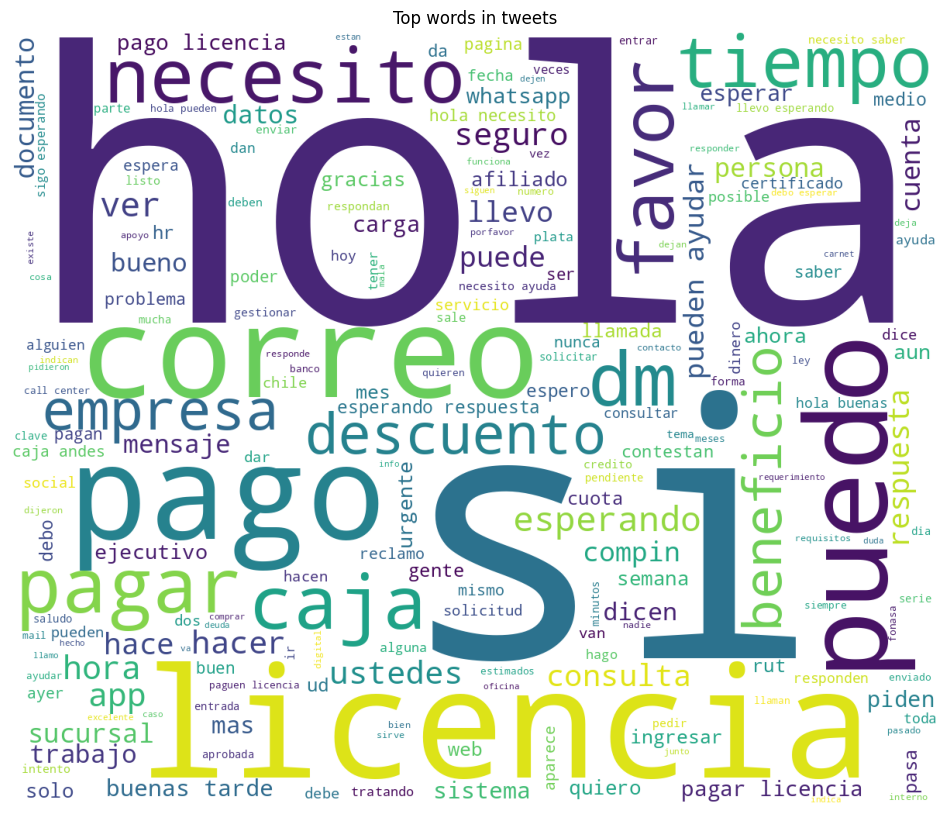

In [76]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

plt.figure(figsize = (12, 12))
text = ' '.join(df_2['preprocessed_tweet'])
wordcloud = WordCloud(max_font_size=None, background_color='white', width=1200, height=1000).generate(text)
plt.imshow(wordcloud)
plt.title('Top words in tweets')
plt.axis("off")
plt.show()

In [82]:
df_2[["tweet"]]

tweet
2                                                                                                                                                                                                                                                                    @CajaLosAndes Hola, Les envié DM para que me puedan ayudar con un tema por favor.
5                                                                                                                                                                                                         RT @IgualesChile: 🏅Fuimos reconocid@s por @ElMercurio_cl y @CajaLosAndes en el Especial de Innovación Social como una de las "70 iniciativa…
8                                                            Hola a todos!, espero que estén teniendo una buena semana.\n\nPor si no se habían dado cuenta, estoy participando en una startup que se llama apanio, que tiene como propósito acortar la brecha digital de los microempresarios de Chile…https://t.co/bepUDTAY4C https://t.co/1gQ04v1CF0
9                                                                                                                                                                                                                                                                                                  @CajaLosAndes Hola, envié un DM, ¿me pueden ayudar?
12                                                                                              EN VIVO | Premio a la Trayectoria, presentado por @CajaLosAndes es para Valeria Lucca, de @audaxitaliano, y quien anunció su retiro de la actividad.\n\nSigue la ceremonia de los #PremiosFutFem en nuestro canal de YouTube.\nhttps://t.co/FzMqwZSQum
...                                                                                                                                                                                                                                                                                                                                                ...
2139                                                                                                                                                                                                                                                                                   @CajaLosAndes \nEs seguro señalar la cuenta corriente en tapp??
2140                                                                                                                                                                                                                                                      @CajaLosAndes algun ejecutivo para consultar sobre un seguro de vida que se me esta cobrando
2143                                                               Hoy fui a @CajaLosAndes a ver qué pasaba con el pago de mi licencia y me informan que no me pagarán porque no me aparecen mis cotizaciones de fonasa y solo quiero decir POR QUÉ NO ME LO DIJERON EN UN PRINCIPIO? Un mes esperando, con ansiedad, para que recién me digan que no?
2148                                                                                                                                               Me llamaron de @CajaLosAndes para ofrecerme un seguro y me preguntaron si soy casada. Dije que firmé AUC y me responde “entonces soltera”. ¿Vieron por qué era necesario el matrimonio igualitario?
2149  @yesseni55730686 @tiomattu @CajaLosAndes @gabrielboric Y cuanto alcanzaste a pagar? Cuantas cuotas ?\n\nEn todo caso está todo dentro de norma, tu repactacte y si no actívate el seguro y después dejaste de pagar... Uno responde con su patrimonio.\n\nLo que si te advierto que esto es rápido... Así que debes moverte, ya te notificaron ?

[1026 rows x 1 columns]

Dentro de este clustering priman el saludo y conceptos referentes a solicitudes muy por encima de otros conceptos, por tanto puede llegar a tener una connotación neutra. Este cluster es el más grande y dada la complejidad del lenguaje puede llegar a tener sentido que el grupo mayor sea de tweets neutros o difíciles de agrupar.

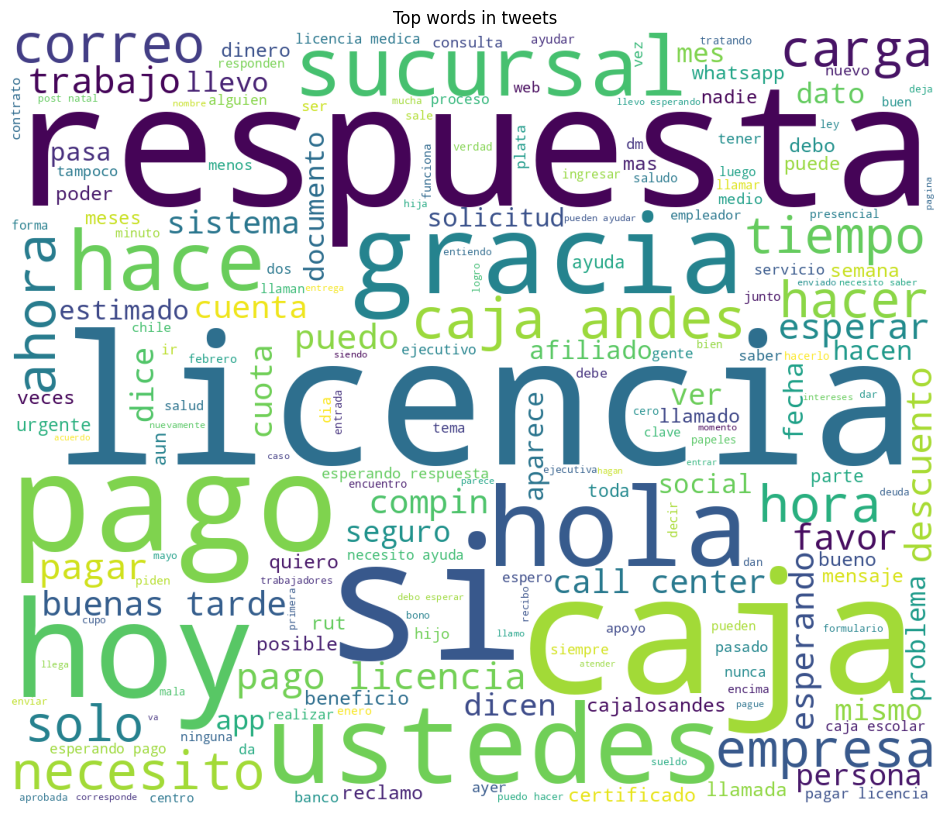

In [78]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

plt.figure(figsize = (12, 12))
text = ' '.join(df_3['preprocessed_tweet'])
wordcloud = WordCloud(max_font_size=None, background_color='white', width=1200, height=1000).generate(text)
plt.imshow(wordcloud)
plt.title('Top words in tweets')
plt.axis("off")
plt.show()

In [79]:
df_3[["tweet"]]

tweet
0                                             ¡Atención! @ElMercurio_cl y @CajaLosAndes destacaron a #CongresoFuturo como una de las 70 organizaciones inspiradoras y de alto impacto que proponen ideas disruptivas para crear valor social que mejore la calidad de vida de las personas. https://t.co/z6EE581U3n
6                                                                                                                                                @CajaLosAndes Buen día, les escribo porque nuevamente no logro encontrar el descuento de cinepolis, a veces a parece y otras veces no. Favor de su ayuda, gracias!
10             Vota por tu emprendimiento favorito en TECLA 6 dale like 💙 en https://t.co/pAmRy0ggzh\n\nLos 60 finalistas necesitan de tu voto para llegar al pitch day, tienes hasta el 31 de enero para darles tu voto\n\nOJO👀si eres afiliado a Caja Los Andes ¡Tu voto vale el doble!✌️ https://t.co/i8UYphdT0N
11                                                                                            @BlestSergi @CajaLosAndes Estimado @BlestSergi, lamentamos lo que nos cuenta. Por favor, envíenos por DM/inbox sus datos (nombre, Rut, correo electrónico y teléfono) para que podamos ayudarle Quedamos a la espera.
13    Saludo protocolar entre prefecto inspector José Carrasco, jefe de la Región Policial de Coquimbo y Juan Carlos Pesantes, gerente de @CajaLosAndes.\nDesarrollan reunión de trabajo y agenda en conjunto para avanzar en nuevos desafíos, compromisos y realización de proyectos 2023. https://t.co/X4yx4Vpl32
...                                                                                                                                                                                                                                                                                                             ...
2142                                                                                                     🔜⚽ HOY SE INICIA EL CAMINO A LA GLORIA...\n\nYA ESTÁ AQUÍ EL #FemeninoCajaLosAndes 🆕 \n\nQué comience la fiesta‼💯 \n\n🇧🇼 ¡Vamos las celestes! ¡Vamos O'Higgins!💪🏻\n\n@CajaLosAndes https://t.co/COvZOjx1Nj
2144                           @CajaLosAndes estimados a un transcurrido 11 dias de lo sucedido no me han devuelto el dinero y tampoco un llamdo,que mas tengo que esperar por una negligencia de ustedes,que falta de respeto a los afiliados necesito una explicación más necesito mi dinero.\nFAVOR RESPONDER !!
2145                     @CajaLosAndes  cansa rogar que me devuelvan el dinero  mal cobrado, ya tienen la respuesta ustedes mismos  y me indican que debo esperar respuesta el 25....me  tienen esperando todo el mes.sin mi dinero ....no quiero  dm ; hecho el reclamo con @SUSESOChile . https://t.co/8hTj5BkxVN
2146                                                                     @CajaLosAndes Me quedé sin trabajo y debo solo 1 CUOTA DE MI CRÉDITO. YO INFORMÉ QUE A FDM IBA A PAGAR LAS CUOTAS VENCIDAS CORRESPONDIENTE. Y AHORA ME LLEGA UN MENSAJE QUE ME DEMANDARON X NO PAGO!! SE PASAN DE VERDAD, ES SOLO 1 CUOTA.
2147                                                                                                                @CajaLosAndes Necesito agregar mis datos bancarios para el pago de una licencia, y también activar mi seguro de cesantía por un crédito y sistema arroja error desde ayer. Excelente servicio 😒

[965 rows x 1 columns]

Ahora, este último clustering podría tratarse de uno con sentimientos un poco más negativos, ligados a la necesidad de respuestas, pagos y demandas. Dentro de este clustering no prima tanto el saludo, por ejemplo. Además, dentro de los ejemplos, la mayoría de los tweet mantienen una connotación negativa o de reclamo.

# Conclusiones

Dentro del análisis se pudo apreciar que los tweets de Caja Los Andes pueden llegar a ser diferenciables en cuanto al contexto de sus sentimientos. Esto requiere de un tratamiento de datos que se podría llevar muchísimo más lejos de lo que se vió en este pequeño análisis de prueba.

Dentro de otros análisis que se podrían considerar, podría ser el agregar contadores de palabras en base a su connotación. Para esto habría que considerar también diccionarios de palabras en español con su etiqueta de sentimientos.

Lo otro que se podría considerar es etiquetar un buen tramo de estos datos y entrenar un modelo personalizado a los tweets de Caja Los Andes. Sino, mantenerse en la línea de los modelos pre entrenados, pero también con una personalización en el entrenamiento de estos.